# Transfer learning: Vision Transformer

In [11]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import torch
import torch.nn as nn
from huggingface_hub import notebook_login
from datasets import load_dataset, DatasetDict
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments
import evaluate

In [2]:
notebook_login()

## Load and Explore the dataset

In [12]:
dataset = load_dataset('pcuenq/oxford-pets')
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

In [13]:
dataset['train'][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xf4\x01Y\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\

In [5]:
labels = dataset['train'].unique('label')
print(len(labels),labels)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


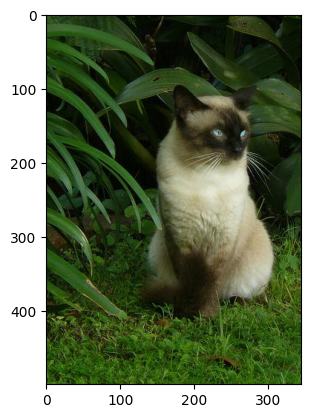

In [14]:
def show_image_from_bytes(image_bytes):
    """
    Displays an image from its bytes representation.

    Args:
        image_bytes: The bytes data of the image.
    """

    # Create a BytesIO object from the image bytes
    img = Image.open(io.BytesIO(image_bytes))

    img_array = np.array(img)

    # Display the image
    plt.imshow(img_array)
    plt.show()

show_image_from_bytes(dataset['train'][0]['image']['bytes'])


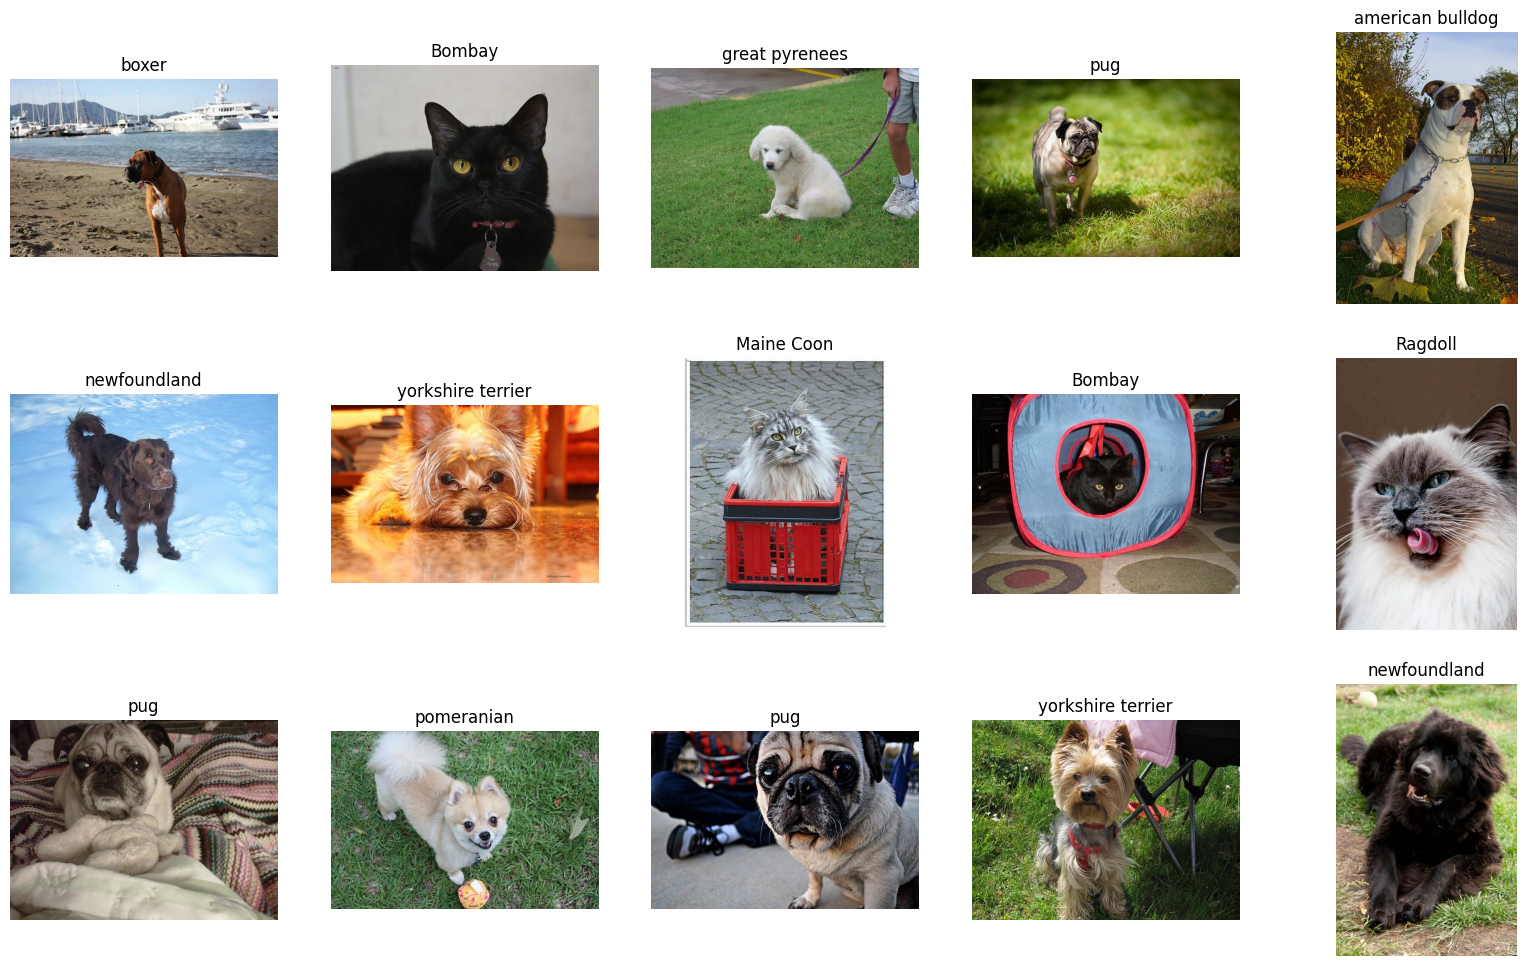

In [16]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        image_bytes = samples[i]['image']["bytes"]
        # Create a BytesIO object from the image bytes
        img = Image.open(io.BytesIO(image_bytes))
        img_array = np.array(img)
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img_array)
        plt.title(label)
        plt.axis('off')
            
show_samples(dataset['train'],rows=3,cols=5)

## Preprocessing our dataset

In [17]:
split_dataset = dataset['train'].train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 1478
    })
})

In [18]:
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)
eval_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

In [19]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 1478
    })
})

In [20]:
our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})
our_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

In [21]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

### Image Processor

In [24]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs